In [ ]:
%matplotlib inline
import glob
from dataclasses import dataclass
from typing import Dict, List

import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from IPython.display import display, HTML

from lib import parametrization as par
from lib import work_dir

sns.set(font_scale=1.75)
color_map = sns.light_palette("green", as_cmap=True)


@dataclass
class ExperimentArguments:
    language: str
    transformation: str
    fuzzing_strategy: str
    subject: str


class CoverageReportLoader:
    def __init__(self, args: ExperimentArguments):
        self._args = args

    def _create_path_patterns(self):
        shared_prefix = f"{work_dir}/coverage-reports/{self._args.language}"
        shared_suffix = f"{self._args.fuzzing_strategy}/{self._args.subject}"
        after_subdir = self._args.transformation
        before_subdir = "identity"
        after_pattern = f"{shared_prefix}/{after_subdir}/{shared_suffix}/run*/coverage.csv"
        before_pattern = f"{shared_prefix}/{before_subdir}/{shared_suffix}/run*/coverage.csv"
        return after_pattern, before_pattern

    def _find_matching_paths(self):
        after_pattern, before_pattern = self._create_path_patterns()
        after_paths = glob.glob(after_pattern, recursive=True)
        before_paths = glob.glob(before_pattern, recursive=True)
        no_paths = not after_paths or not before_paths
        if no_paths:
            raise FileNotFoundError(f"No matching coverage reports found for {self._args}.")
        all_paths_are_paired = len(after_paths) == len(before_paths)
        if not all_paths_are_paired:
            raise FileNotFoundError(f"Missing some coverage reports for {self._args}.")
        return after_paths, before_paths

    def _read_csv_and_check_nonempty(self, path):
        csv = pd.read_csv(path, usecols=["filenum", "branch"])
        if csv.empty:
            raise ValueError(f"Empty coverage report read for {self._args}, path = {path}.")
        return csv

    def load_coverage_reports(self):
        after_paths, before_paths = self._find_matching_paths()
        after_coverages = [self._read_csv_and_check_nonempty(path) for path in after_paths]
        before_coverages = [self._read_csv_and_check_nonempty(path) for path in before_paths]
        return after_coverages, before_coverages


class CoveragePlotter:
    def __init__(self, args: ExperimentArguments):
        self._args = args
        self._loader = CoverageReportLoader(self._args)

    def _concat_coverage_reports(self):
        after_coverages, before_coverages = self._loader.load_coverage_reports()
        after_df = pd.concat(after_coverages)
        before_df = pd.concat(before_coverages)
        return after_df, before_df

    def _make_comparison_df(self):
        after_df, before_df = self._concat_coverage_reports()
        after_df["transformation"] = self._args.transformation
        before_df["transformation"] = "identity"
        return pd.concat((after_df, before_df), sort=False, ignore_index=True)

    def _make_title(self):
        return f"Language {self._args.language}, Subject {self._args.subject}, Strategy {self._args.fuzzing_strategy}"

    def _plot_mean_coverage_comparison(self, comparison_df):
        plt.figure(figsize=(20, 8))
        ax = sns.lineplot(data=comparison_df, x="filenum", y="branch", hue="transformation", style="transformation",
                          dashes=False, ci=95)  # , units="run", estimator=None)
        title = self._make_title()
        ax.set_title(title)
        ax.set_xlabel("Number of Files")
        ax.set_ylabel("Mean Branch Coverage")

    def _plot_scatter_coverage_comparison(self, comparison_df):
        plt.figure(figsize=(20, 8))
        ax = sns.scatterplot(data=comparison_df, x="filenum", y="branch", hue="transformation", style="transformation",
                             alpha=0.5)
        title = self._make_title()
        ax.set_title(title)
        ax.set_xlabel("Number of Files")
        ax.set_ylabel("Branch Coverage")

    def plot_coverage_comparisons(self):
        comparison_df = self._make_comparison_df()
        self._plot_mean_coverage_comparison(comparison_df)
        self._plot_scatter_coverage_comparison(comparison_df)


class PlotterParametrizer:
    def __init__(self):
        self._per_transformation_args: Dict[str, List[ExperimentArguments]] = {}
        self._assemble_args()

    def _add_new_args_for_transformation(self, transformation, args):
        if transformation in self._per_transformation_args:
            self._per_transformation_args[transformation].append(args)
        else:
            self._per_transformation_args[transformation] = [args]

    def _assemble_args(self):
        for language in par.languages:
            for transformation in par.transformations:
                for fuzzing_strategy in par.fuzzing_strategies:
                    for subject in par.subjects[language]:
                        args = ExperimentArguments(language, transformation, fuzzing_strategy, subject)
                        self._add_new_args_for_transformation(transformation, args)

    def parametrize_plotters(self):
        per_transformation_plotters = {
            transformation: [CoveragePlotter(args) for args in transformation_args]
            for transformation, transformation_args in self._per_transformation_args.items()
        }
        return per_transformation_plotters


class PlotterExecutor:
    def __init__(self, per_transformation_plotters: Dict[str, List[CoveragePlotter]]):
        self._per_transformation_plotters = per_transformation_plotters

    def execute_transformation_plotters(self, transformation: str):
        for plotter in self._per_transformation_plotters[transformation]:
            try:
                plotter.plot_coverage_comparisons()
            except Exception as e:
                print(str(e))


class StatisticsReportLoader:
    def __init__(self, transformation: str, metric: str):
        self._transformation = transformation
        self._metric = metric

    def _create_path_pattern(self):
        transformation_subdir = f"{work_dir}/results/*/{self._transformation}/*/*"
        metric_suffix = f"{self._metric}/{self._metric}-diff-report.csv"
        return f"{transformation_subdir}/{metric_suffix}"

    def _find_matching_paths(self):
        pattern = self._create_path_pattern()
        matching_paths = glob.glob(pattern, recursive=True)
        no_paths = not matching_paths
        if no_paths:
            raise FileNotFoundError(
                f"No matching {self._metric} statistics reports found for {self._transformation}.")
        return matching_paths

    def _read_csv_and_check_nonempty(self, path):
        csv = pd.read_csv(path)
        if csv.empty:
            raise ValueError(
                f"Empty {self._metric} statistics report read for {self._transformation}, path = {path}.")
        formatted_csv = csv.drop(["metric", "transformation"], axis=1)
        return formatted_csv

    def load_statistics_reports(self):
        report_paths = self._find_matching_paths()
        return [self._read_csv_and_check_nonempty(path) for path in report_paths]


class StatisticsReporter:
    def __init__(self, transformation: str, metric: str):
        self._loader = StatisticsReportLoader(transformation, metric)
        self._metric = metric

    def _concat_statistics_reports(self):
        statistics_reports = self._loader.load_statistics_reports()
        df = pd.concat(statistics_reports)
        sorted_df = df.sort_values(["language", "fuzzing strategy", "subject"])
        return sorted_df

    def _format_df(self, df: pd.DataFrame):
        return df.round(decimals=4)

    def draw_metric_table(self):
        raw_df = self._concat_statistics_reports()
        formatted_df = self._format_df(raw_df)
        display(HTML(formatted_df.to_html(index=False)))


parametrizer = PlotterParametrizer()
plotters = parametrizer.parametrize_plotters()
executor = PlotterExecutor(plotters)

backus-naur-form
-coverage:


language,fuzzing strategy,subject,mean difference,median difference,min difference,max difference,wilcoxon (two-sided),p-value (two-sided),wilcoxon (greater),p-value (greater)
json,200-random-100,argo,0.0000,0.0000,0.0000,0.0000,NaN,NaN,NaN,NaN
json,200-random-100,json-simple,0.0000,0.0000,0.0000,0.0000,NaN,NaN,NaN,NaN
json,recurrent-2-path-100,argo,0.0049,0.0055,-0.0037,0.0110,200.0,0.0000,4456.0,0.0000
json,recurrent-2-path-100,json-simple,0.0013,0.0000,-0.0055,0.0055,28.0,0.0000,350.0,0.0000
url,200-random-100,jurl,-0.1941,-0.2219,-0.3510,-0.0166,0.0,0.0000,0.0,1.0000
url,recurrent-2-path-100,jurl,0.0017,0.0033,-0.0364,0.0430,2074.0,0.4441,2486.0,0.2221


-coverage growth rate:


language,fuzzing strategy,subject,mean difference,median difference,min difference,max difference,wilcoxon (two-sided),p-value (two-sided),wilcoxon (greater),p-value (greater)
json,200-random-100,argo,-0.0029,0.0000,-0.0571,0.0497,1820.5,0.1202,1820.5,0.9399
json,200-random-100,json-simple,0.0000,0.0000,0.0000,0.0000,NaN,NaN,NaN,NaN
json,recurrent-2-path-100,argo,1.0119,1.0543,0.1934,1.5948,0.0,0.0000,5050.0,0.0000
json,recurrent-2-path-100,json-simple,0.8002,0.8077,0.1071,1.3736,0.0,0.0000,5050.0,0.0000
url,200-random-100,jurl,-19.4495,-22.1738,-31.8278,3.6490,11.0,0.0000,11.0,1.0000
url,recurrent-2-path-100,jurl,-0.7410,-0.6672,-4.4536,3.2781,1349.0,0.0001,1349.0,1.0000


chomsky-normal-form
-coverage:


language,fuzzing strategy,subject,mean difference,median difference,min difference,max difference,wilcoxon (two-sided),p-value (two-sided),wilcoxon (greater),p-value (greater)
json,200-random-100,argo,0.1768,0.1906,0.1068,0.2541,0.0,0.0,5050.0,0.0
json,200-random-100,json-simple,0.4007,0.4038,0.3516,0.4286,0.0,0.0,5050.0,0.0
json,recurrent-2-path-100,argo,0.0050,0.0055,-0.0055,0.0129,139.5,0.0,4046.5,0.0
json,recurrent-2-path-100,json-simple,0.0963,0.0962,0.0769,0.1044,0.0,0.0,5050.0,0.0
url,200-random-100,jurl,0.0443,0.0430,-0.0132,0.1325,10.5,0.0,4939.5,0.0
url,recurrent-2-path-100,jurl,0.0154,0.0132,-0.0364,0.0530,307.5,0.0,4348.5,0.0


-coverage growth rate:


language,fuzzing strategy,subject,mean difference,median difference,min difference,max difference,wilcoxon (two-sided),p-value (two-sided),wilcoxon (greater),p-value (greater)
json,200-random-100,argo,13.4459,12.1731,8.9374,23.1529,0.0,0.0000,5050.0,0.0
json,200-random-100,json-simple,34.1555,34.2706,27.9176,39.0989,0.0,0.0000,5050.0,0.0
json,recurrent-2-path-100,argo,0.1216,0.1464,-0.6151,0.7532,1352.0,0.0001,3698.0,0.0
json,recurrent-2-path-100,json-simple,7.7498,7.7692,6.5714,8.5797,0.0,0.0000,5050.0,0.0
url,200-random-100,jurl,6.8116,6.6275,-2.0099,23.6291,6.0,0.0000,5044.0,0.0
url,recurrent-2-path-100,jurl,0.7878,0.8957,-5.0033,3.2152,758.0,0.0000,4292.0,0.0


C:\Users\schue\AppData\Local\Temp/ipykernel_5636/2394433120.py:85: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure(figsize=(20, 8))


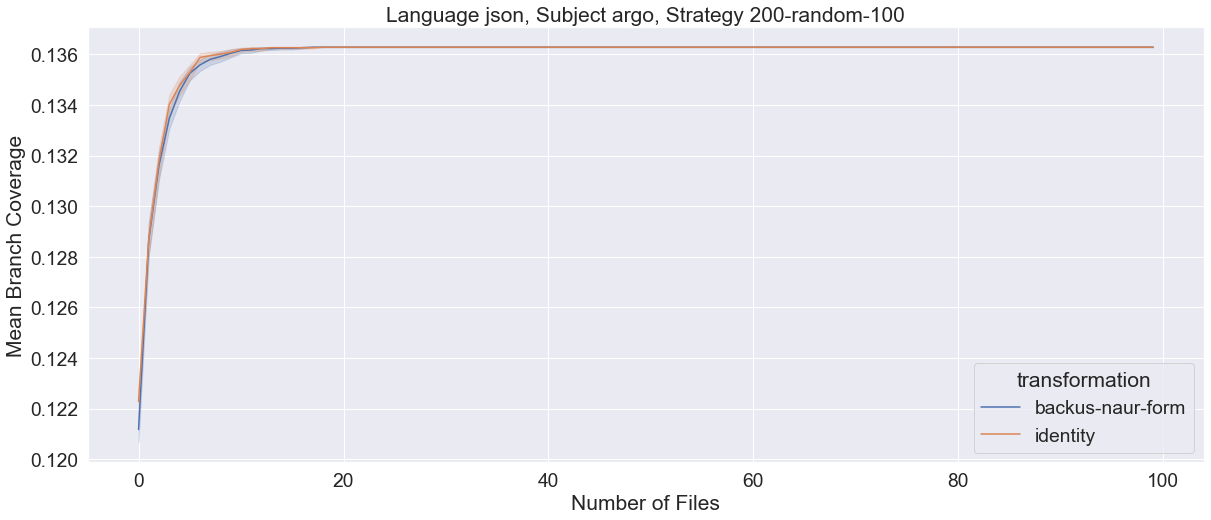

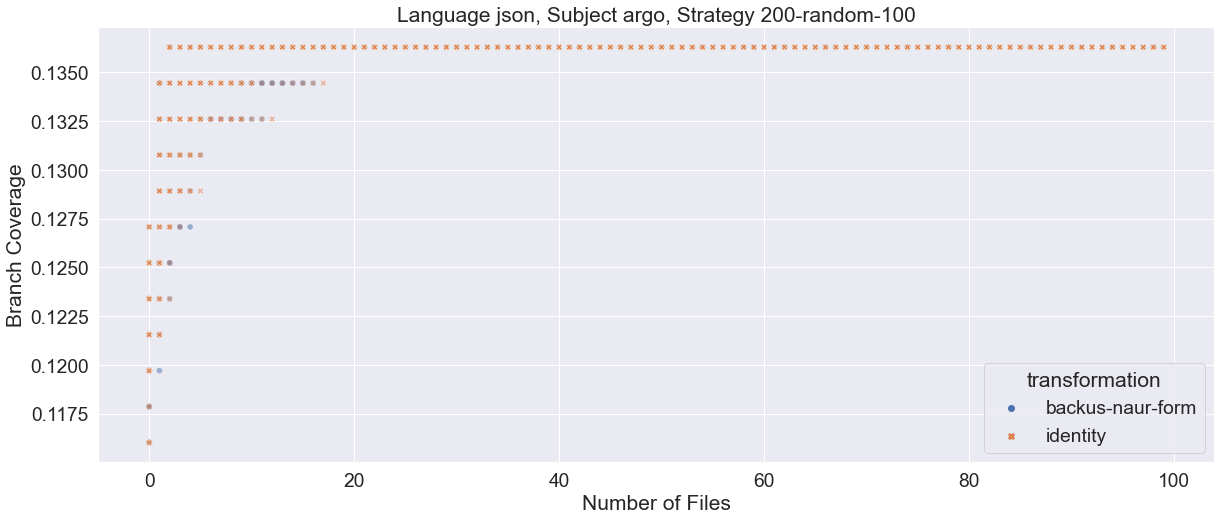

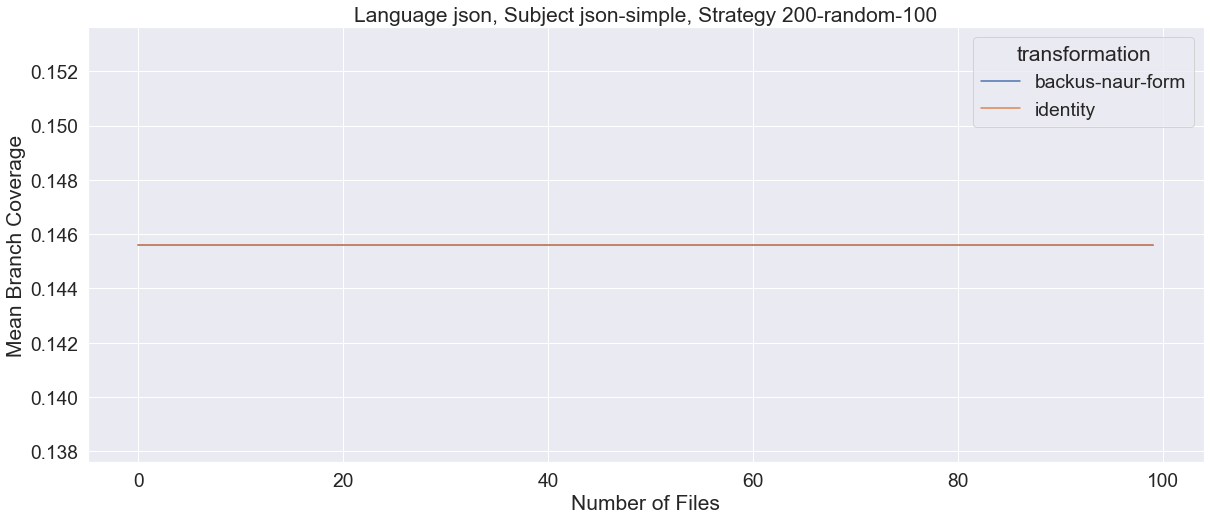

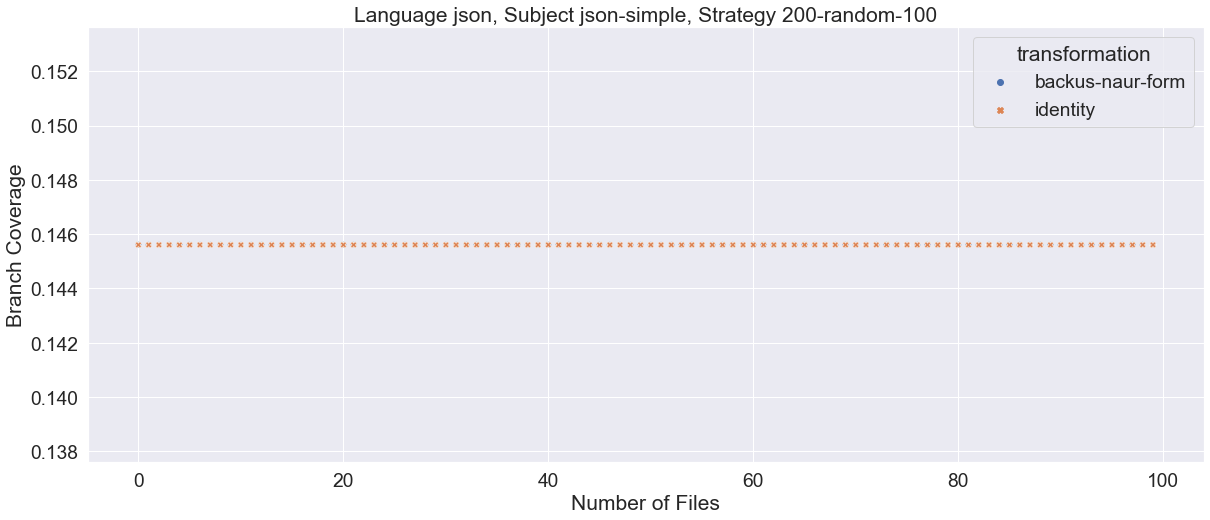

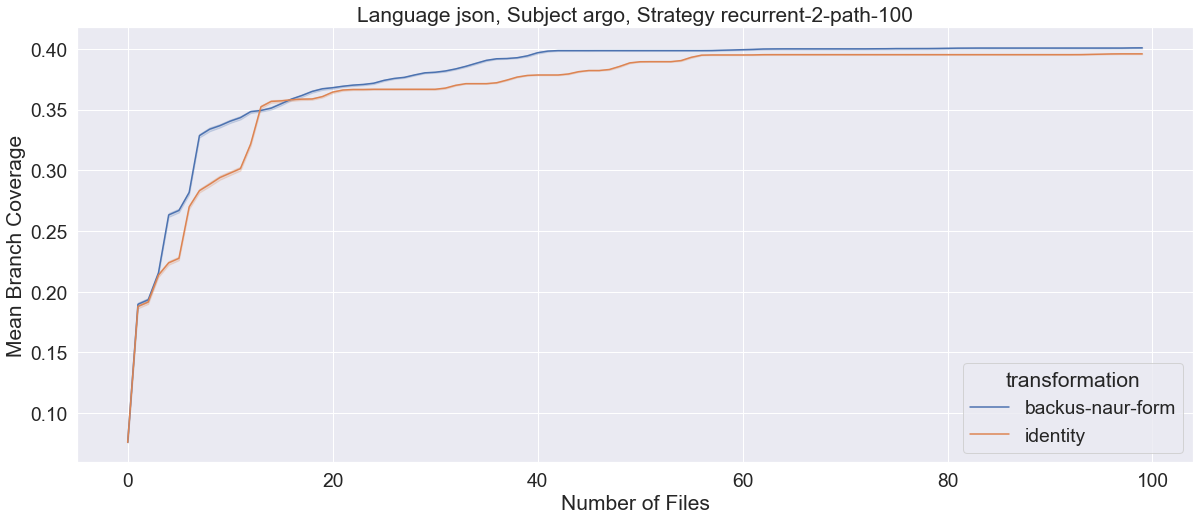

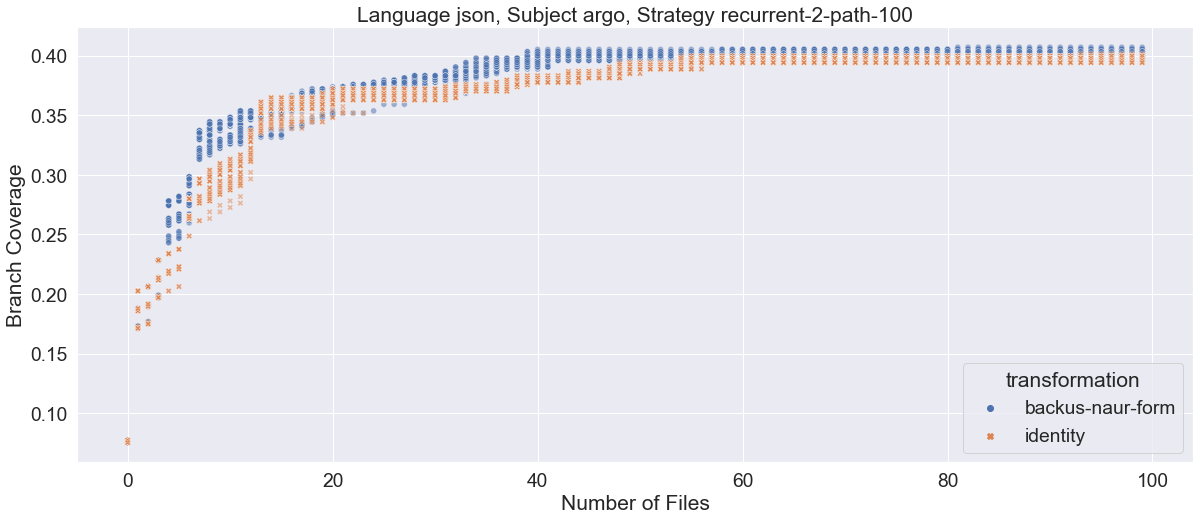

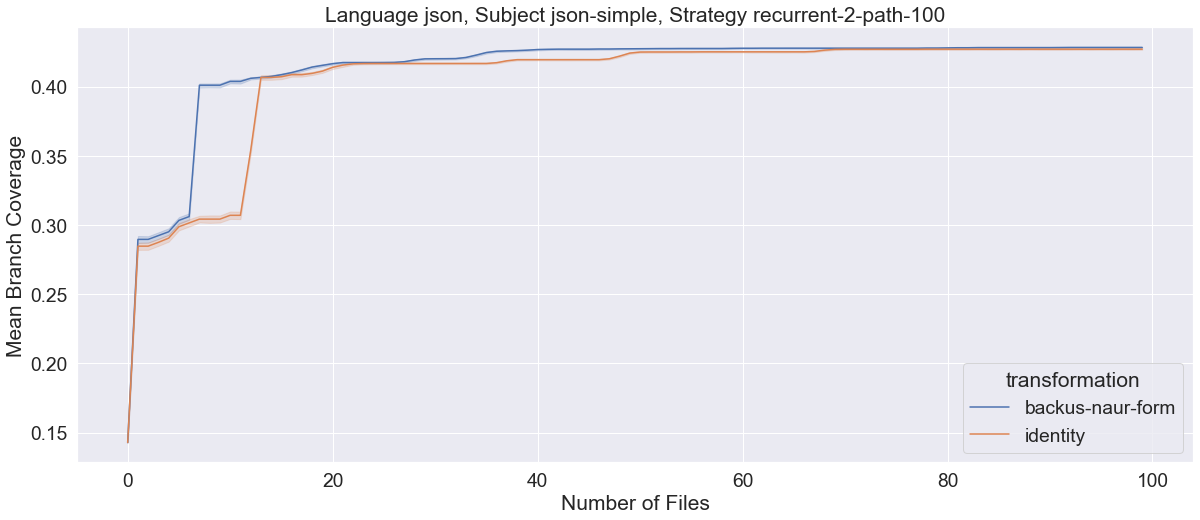

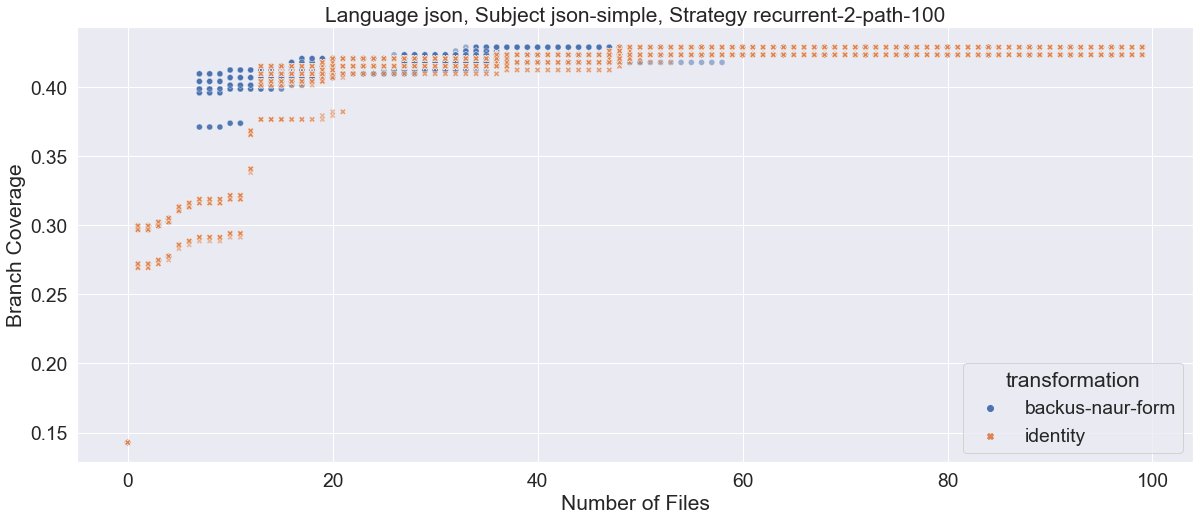

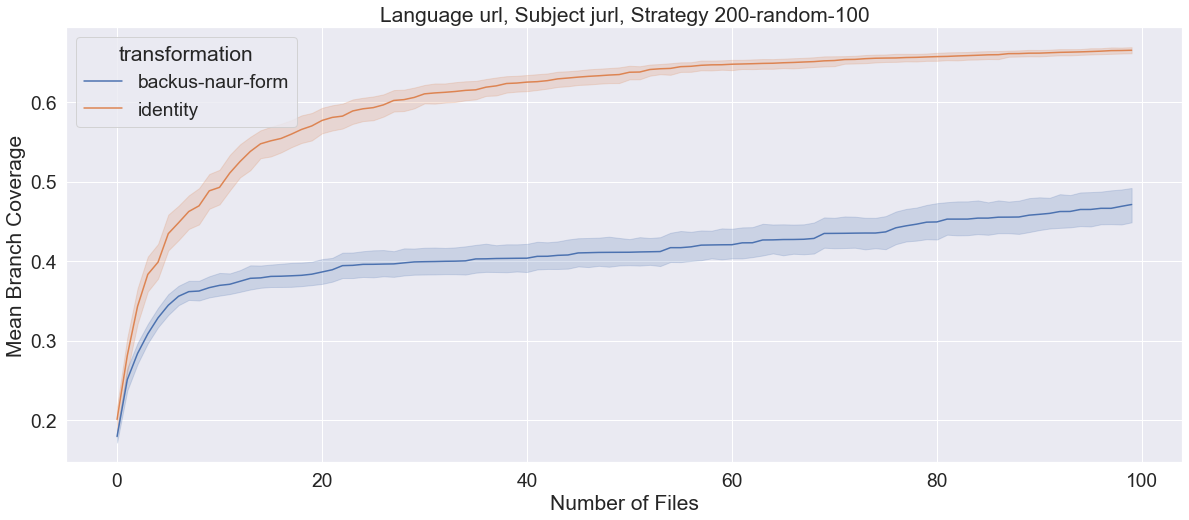

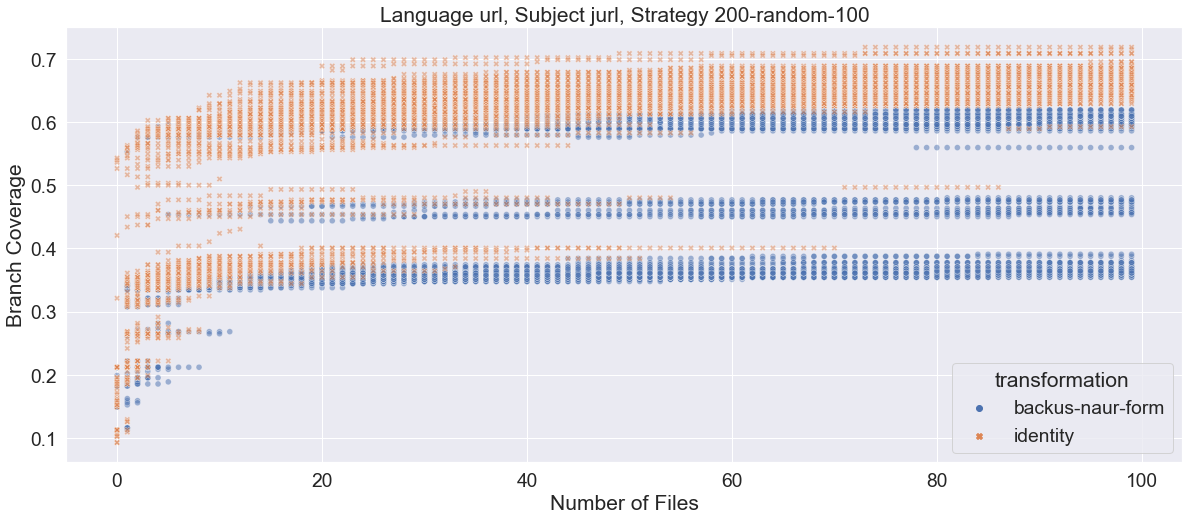

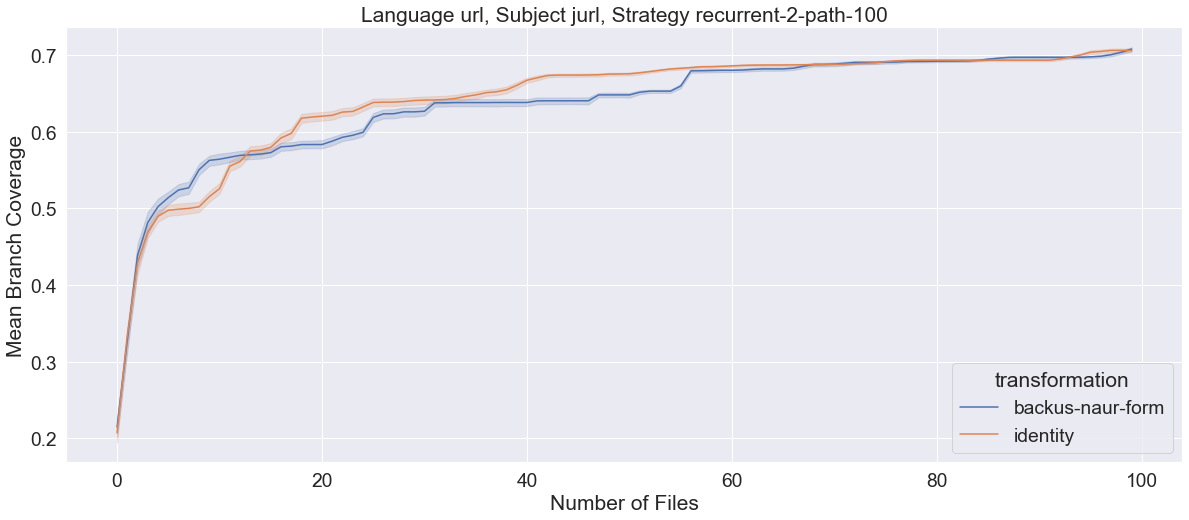

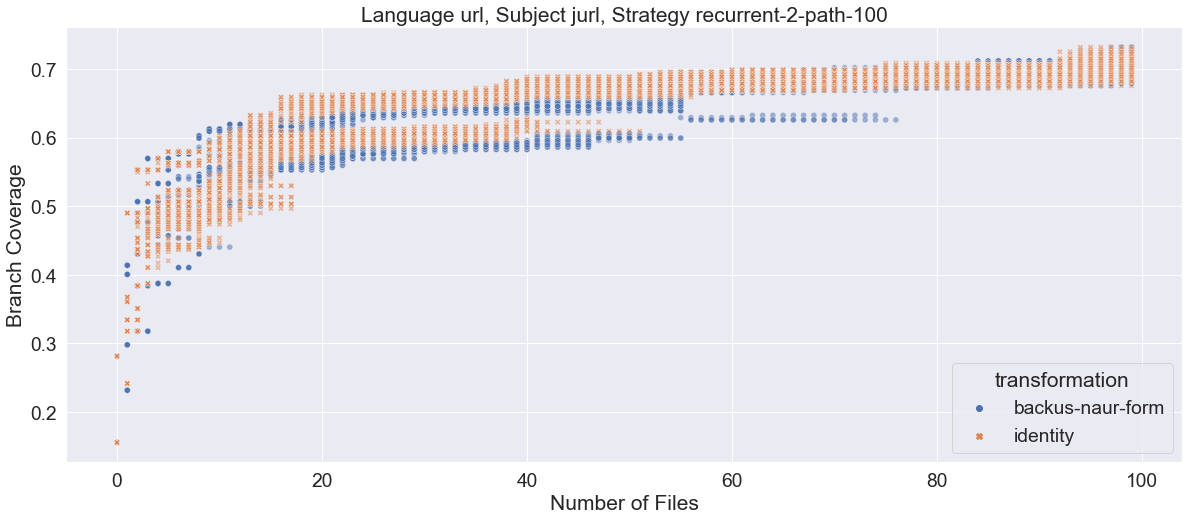

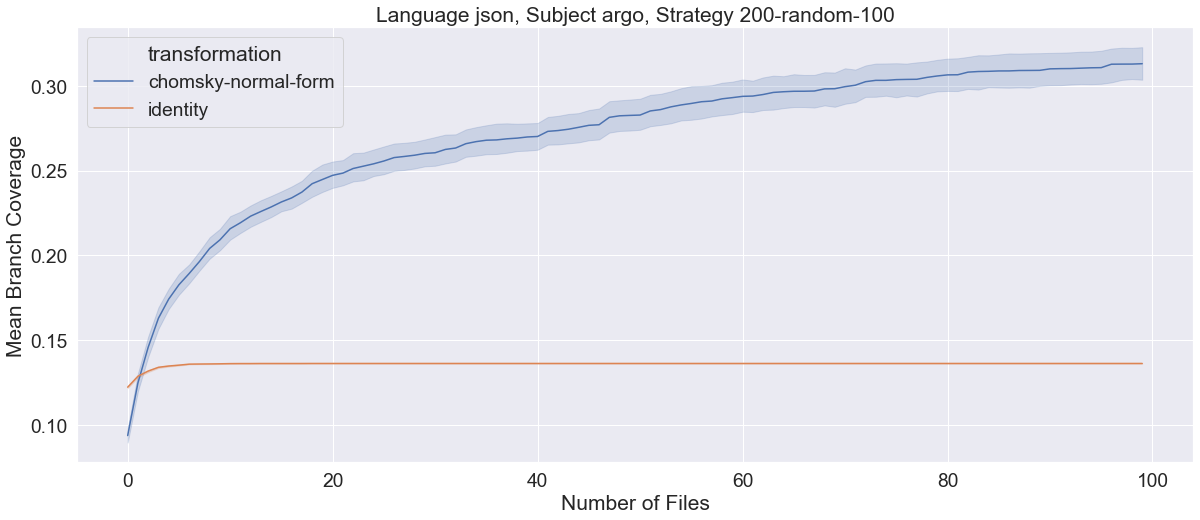

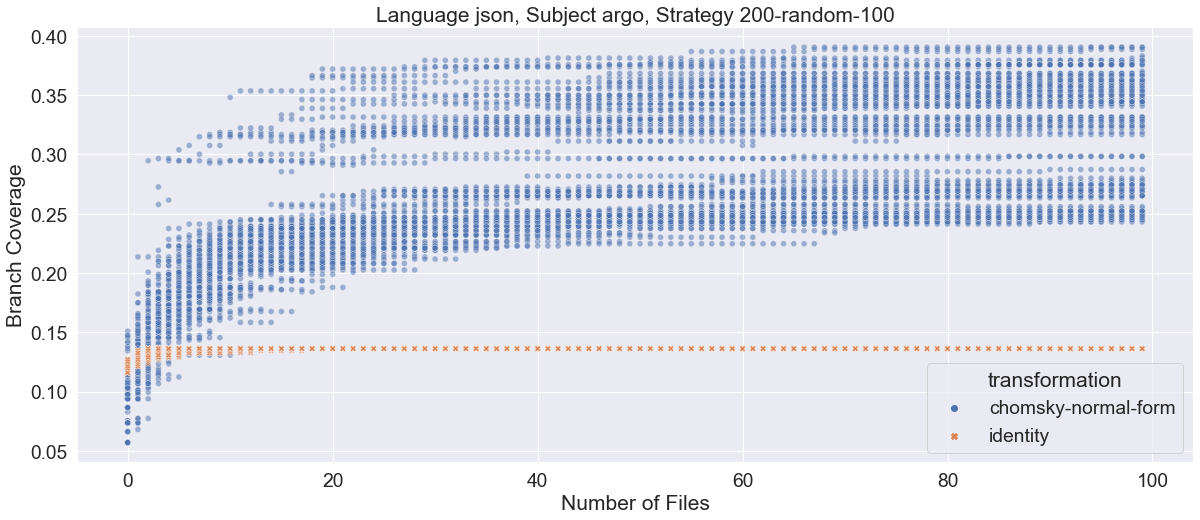

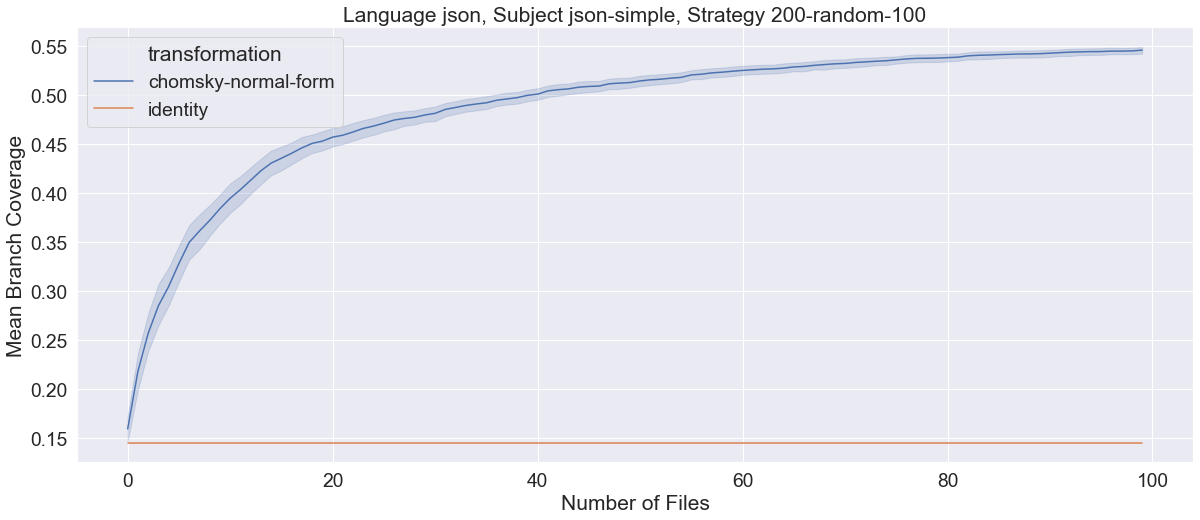

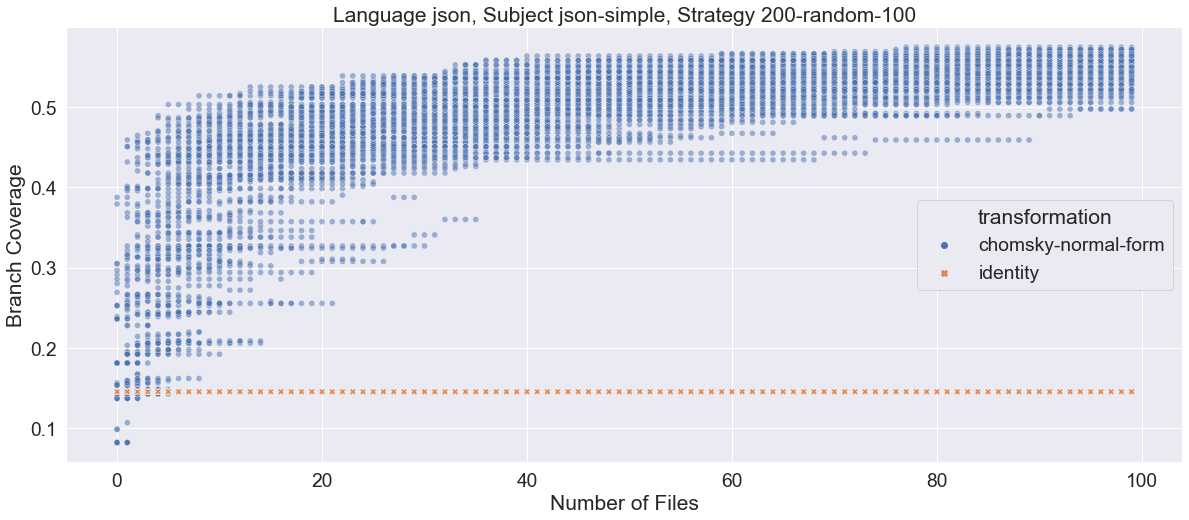

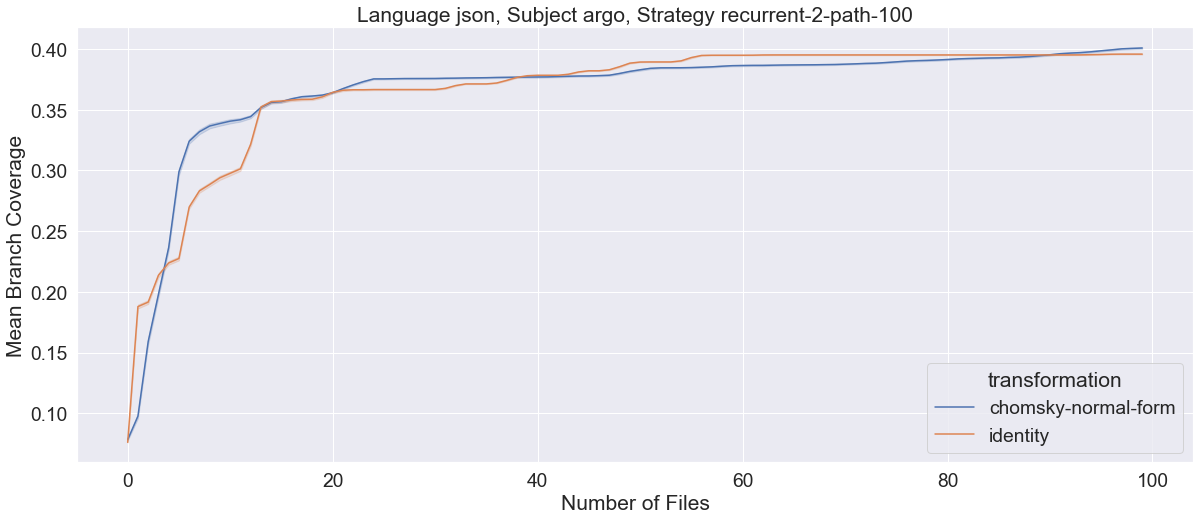

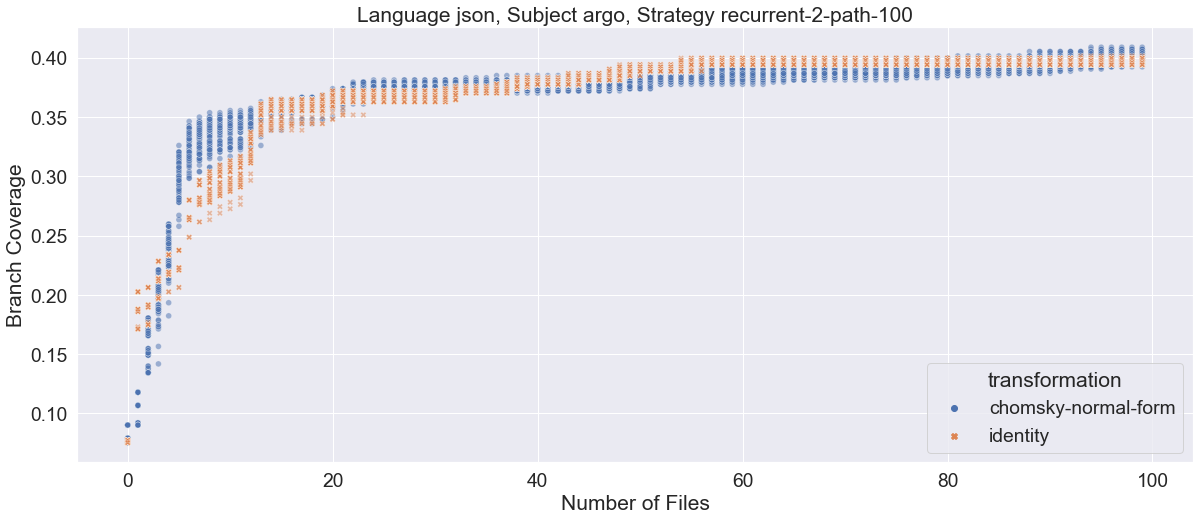

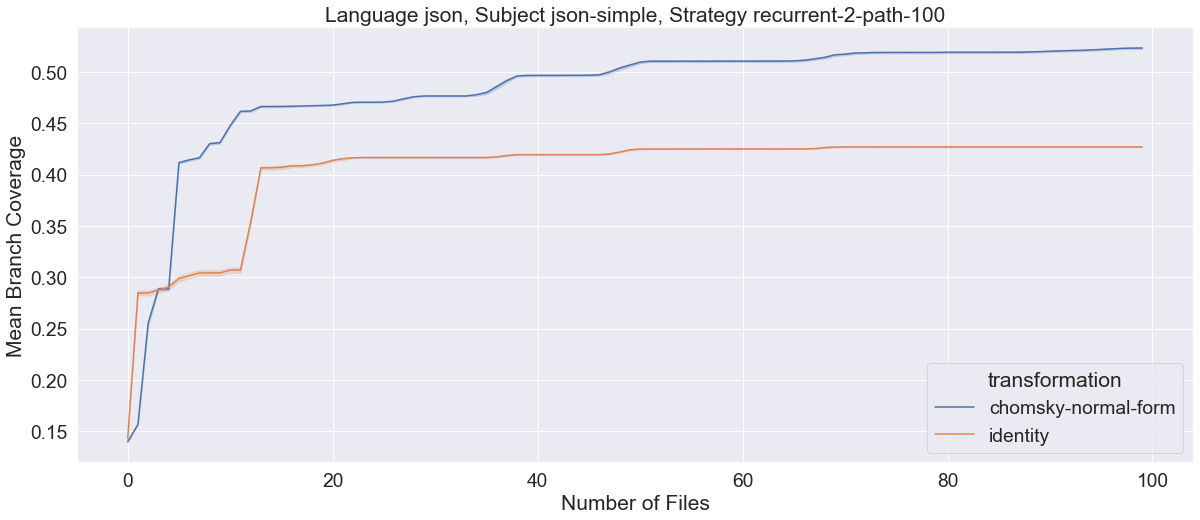

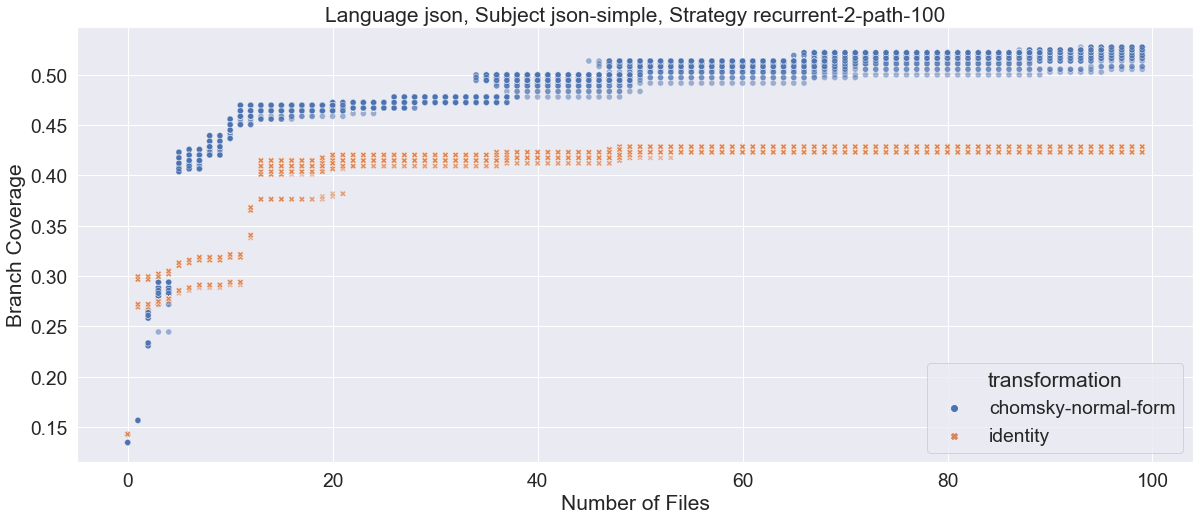

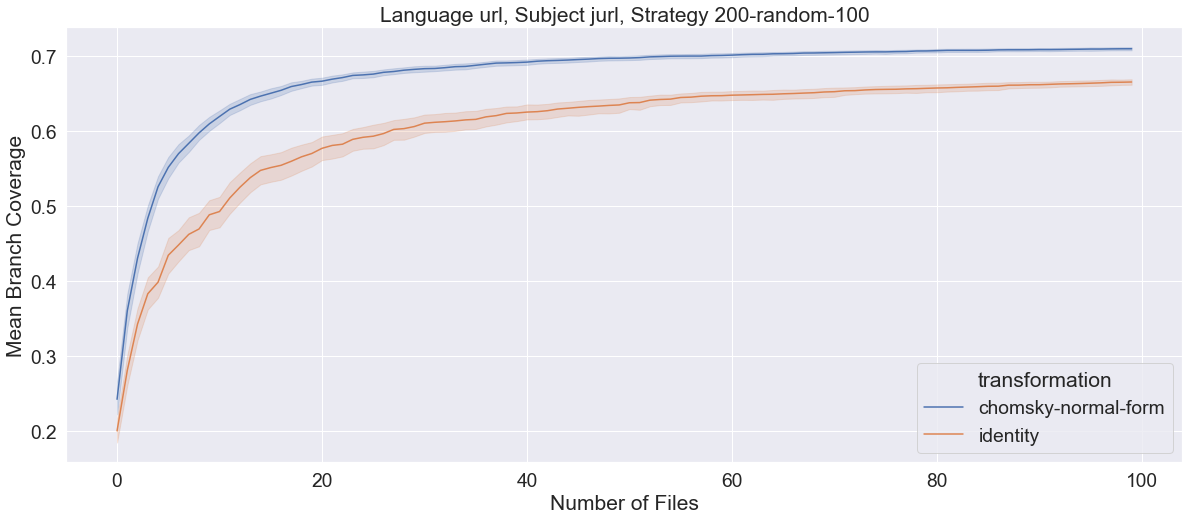

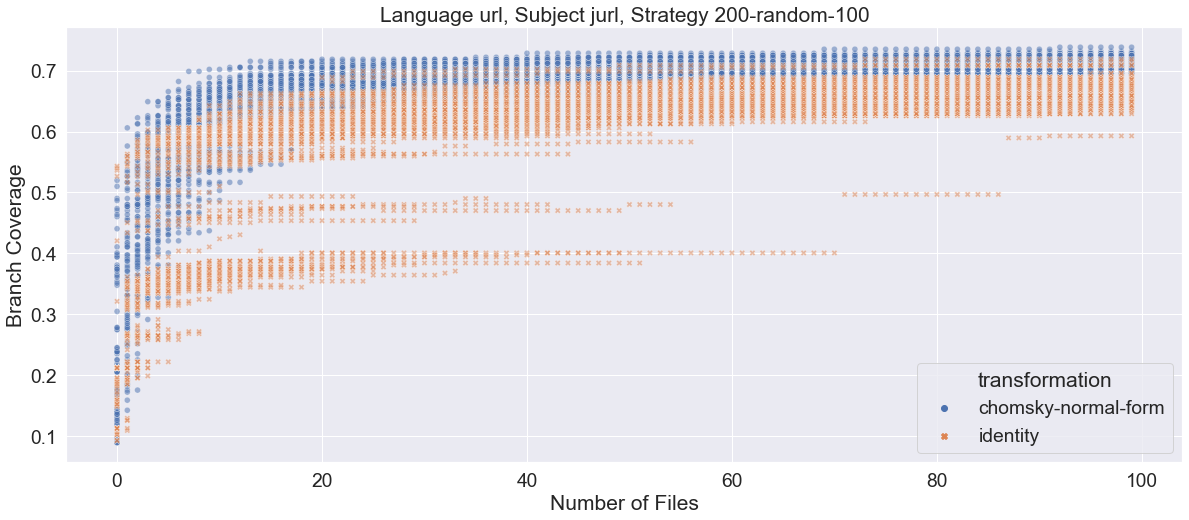

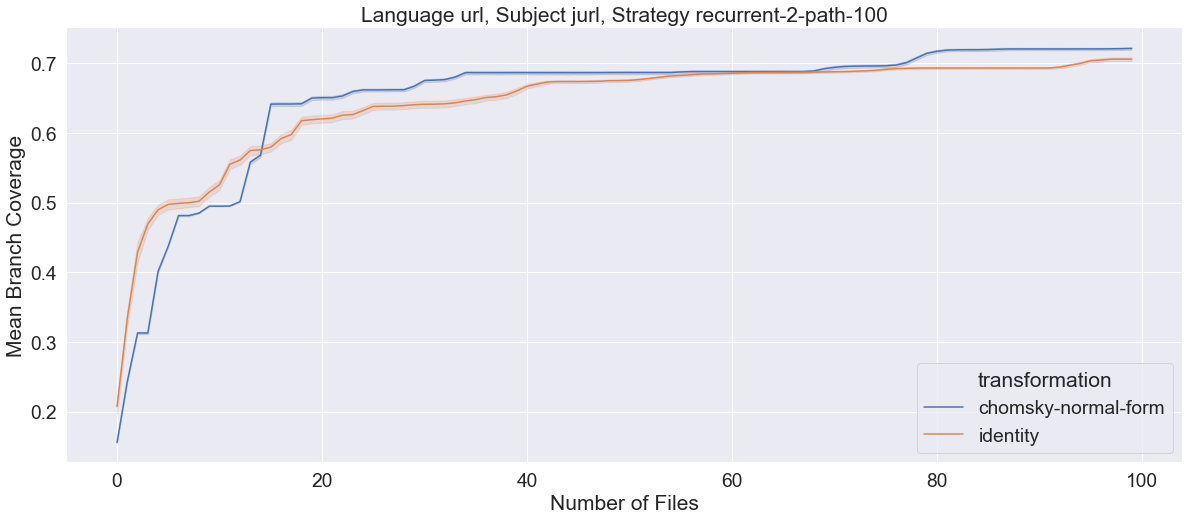

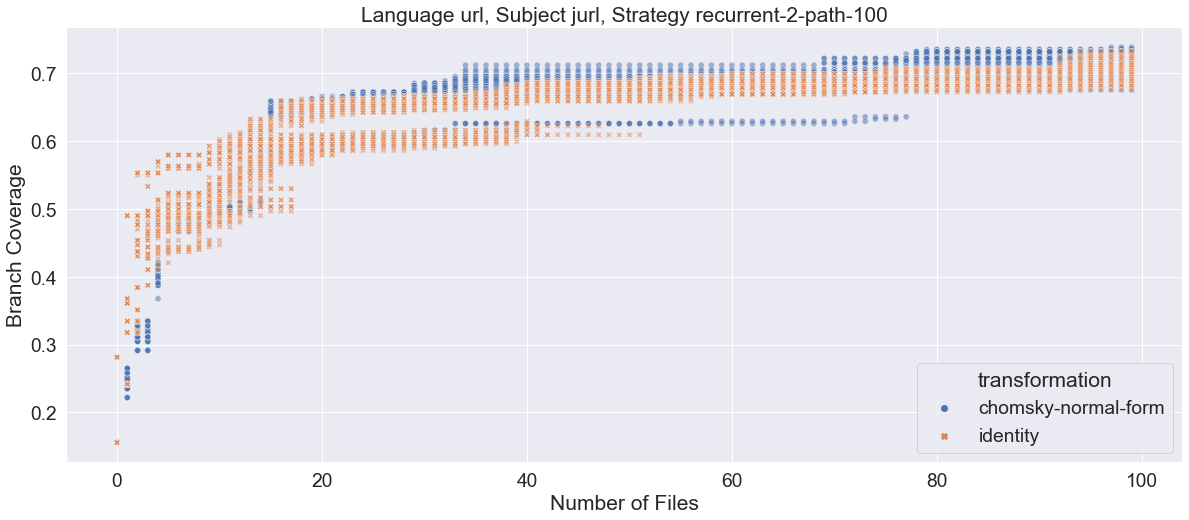

In [4]:
for name in par.transformations:
    print(name)
    coverage_reporter = StatisticsReporter(name, "coverage")
    growth_reporter = StatisticsReporter(name, "coverage-growth-rate")
    print("-coverage:")
    coverage_reporter.draw_metric_table()
    print("-coverage growth rate:")
    growth_reporter.draw_metric_table()
    executor.execute_transformation_plotters(name)

